Importing Required Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Load and Transform Dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:01<00:00, 9.84MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.18MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.15MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.22MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



LeNet-5 Model

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.act1 = nn.Tanh()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.act2 = nn.Tanh()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(120, 84)
        self.act4 = nn.Tanh()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        return x


Initialize Model, Loss Function, and Optimizer

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training and Testing

In [ ]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_loss_train = epoch_loss / len(train_loader)
    avg_accuracy_train = 100 * correct_train / total_train
    train_losses.append(avg_loss_train)
    train_accuracies.append(avg_accuracy_train)

    # Testing the model
    model.eval()
    epoch_loss_test = 0
    correct_test = 0
    total_test = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            epoch_loss_test += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            # Store predictions and labels for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss_test = epoch_loss_test / len(test_loader)
    avg_accuracy_test = 100 * correct_test / total_test
    test_losses.append(avg_loss_test)
    test_accuracies.append(avg_accuracy_test)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss_train:.4f}, Train Accuracy: {avg_accuracy_train:.2f}%, '
          f'Test Loss: {avg_loss_test:.4f}, Test Accuracy: {avg_accuracy_test:.2f}%')

Epoch [1/10], Train Loss: 0.2835, Train Accuracy: 91.68%, Test Loss: 0.0944, Test Accuracy: 97.03%
Epoch [2/10], Train Loss: 0.0863, Train Accuracy: 97.36%, Test Loss: 0.0703, Test Accuracy: 97.88%
Epoch [3/10], Train Loss: 0.0585, Train Accuracy: 98.18%, Test Loss: 0.0610, Test Accuracy: 97.99%
Epoch [4/10], Train Loss: 0.0452, Train Accuracy: 98.57%, Test Loss: 0.0456, Test Accuracy: 98.43%
Epoch [5/10], Train Loss: 0.0382, Train Accuracy: 98.73%, Test Loss: 0.0556, Test Accuracy: 98.21%
Epoch [6/10], Train Loss: 0.0321, Train Accuracy: 98.95%, Test Loss: 0.0510, Test Accuracy: 98.36%
Epoch [7/10], Train Loss: 0.0267, Train Accuracy: 99.14%, Test Loss: 0.0428, Test Accuracy: 98.64%
Epoch [8/10], Train Loss: 0.0239, Train Accuracy: 99.22%, Test Loss: 0.0488, Test Accuracy: 98.39%
Epoch [9/10], Train Loss: 0.0215, Train Accuracy: 99.28%, Test Loss: 0.0478, Test Accuracy: 98.55%
Epoch [10/10], Train Loss: 0.0185, Train Accuracy: 99.39%, Test Loss: 0.0437, Test Accuracy: 98.64%


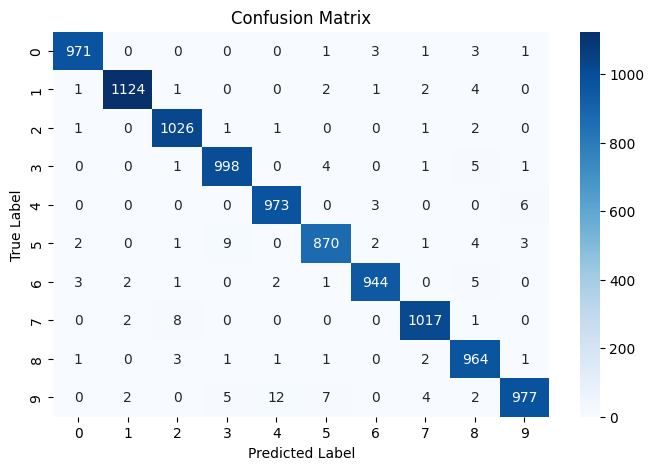

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.98      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.97      0.99      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
def evaluate_model(all_labels, all_preds):
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(8, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Calculate precision, recall, F1 score
    report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)])
    print(report)

# Call the evaluation function
evaluate_model(all_labels, all_preds)

Plotting the training and testing loss and accuracy

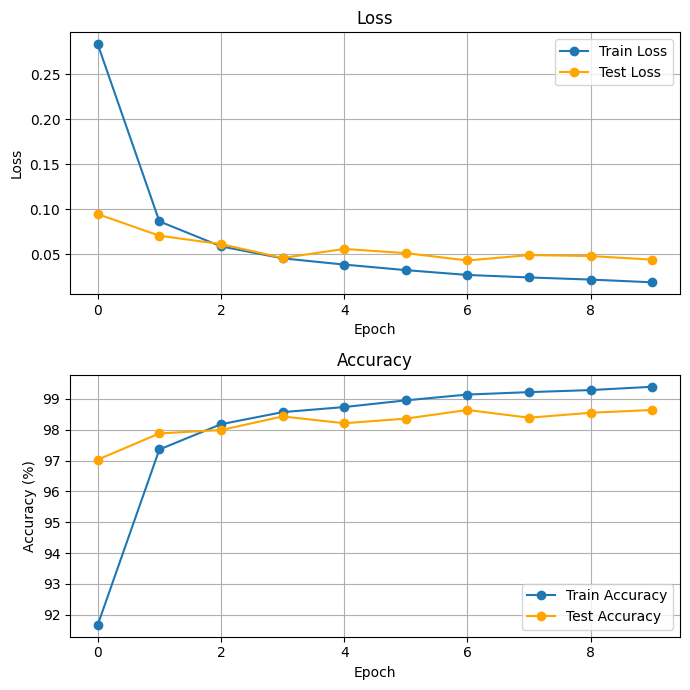

In [ ]:

plt.figure(figsize=(7, 7))

# Plot training and test loss
plt.subplot(2, 1, 1)
plt.plot(train_losses, marker='o', label='Train Loss')
plt.plot(test_losses, marker='o', label='Test Loss', color='orange')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot training and test accuracy
plt.subplot(2, 1, 2)
plt.plot(train_accuracies, marker='o', label='Train Accuracy')
plt.plot(test_accuracies, marker='o', label='Test Accuracy', color='orange')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


Predicting the MINST

In [ ]:
# Function to predict the digit in a single image
def predict_minst(model, image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    transform = transforms.Compose([
        transforms.Resize((28, 28)),  # Resize to 28x28
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)

    return predicted.item()  # Return predicted class

# Example usage
image_path = '/content/9.png'  # Replace with your image path
predicted_digit = predict_minst(model, image_path)
print(f'Predicted Digit: {predicted_digit}')


Predicted Digit: 9
